# Clear Pycache

In [ ]:
import shutil
import os


directory_list = ['', "Data", "Models", "Training", "Notebooks", "Visualizer"]
for directory in directory_list:
    directory = os.path.join("..", directory, "__pycache__")
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Removed {directory}")

# Imports

In [ ]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
import sys
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import ImageShow, Image
import matplotlib.pyplot as plt

from Models import UNet, DeepLabV3_Plus
from Data.dataset import UnetDataSet
from Data.dataloader import get_loaders
from Data.transforms import get_train_transforms, get_val_transforms

from Training.checkpoint import load_checkpoint, save_checkpoint, save_checkpoint

# Cityscapes class Labels

In [ ]:
from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
import numpy as np

id2color = {label.id: np.asarray(label.color) for label in labels}

def decode_mask(encoded_mask):
    encoded_mask = np.array(encoded_mask)
    shape = encoded_mask.shape + (3,)
    decoded_mask = np.zeros(shape, dtype='uint8')

    for label_id, color in id2color.items():
        decoded_mask[encoded_mask == label_id] = color

    return decoded_mask

# Hyperparameters

In [ ]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 105
NUM_WORKERS = 4
IMAGE_HEIGHT = 128
IMAGE_WIDTH = IMAGE_HEIGHT
MAX_BATCH = None
PIN_MEMORY = True
LOAD_MODEL = True
NUM_CLASSES = 35

# Dataset Directories

## Carvana

In [ ]:
TRAIN_IMG_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/train_images'
TRAIN_MASK_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/train_encoded_masks'
VAL_IMG_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/val_images'
VAL_MASK_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/val_encoded_masks'
CHECKPOINT_FIlE = "../Checkpoints/cityscapes_checkpoint_DeepLabV3_Plus.pth"

## Self Driving Cars

image_dir = ["I:/Downloads/Compressed/DATA/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_dir = ["I:/Downloads/Compressed/DATA/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

dataset = UnetDataSet(image_dir, mask_dir, transform=
                            A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
    ]
))


img, mask = dataset[0]

mask = np.longlong(mask)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(mask)
plt.show()

# Load Model

In [ ]:
model = UNet(NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
start_epoch = 0

try:
    if LOAD_MODEL:
        start_epoch = load_checkpoint(ckpt_file=CHECKPOINT_FIlE, model=model, optimizer=optimizer)
except Exception as e:
    print(f"Error loading checkpoint: {str(e)}")
    start_epoch = 0

train_ds = UnetDataSet(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=get_train_transforms(IMAGE_HEIGHT, IMAGE_WIDTH))
val_ds = UnetDataSet(VAL_IMG_DIR, VAL_MASK_DIR, transform=get_val_transforms(IMAGE_HEIGHT, IMAGE_WIDTH))

train_loader, val_loader = get_loaders(
    train_ds,
    val_ds,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
)

# Training Loop

Epoch 3: 100%|██████████| 186/186 [01:24<00:00,  2.20batch/s, Loss=1.76, Pixel Accuracy=0.617, mIoU=0.0833]


=> Epoch 3 is complete
=> Saving checkpoint


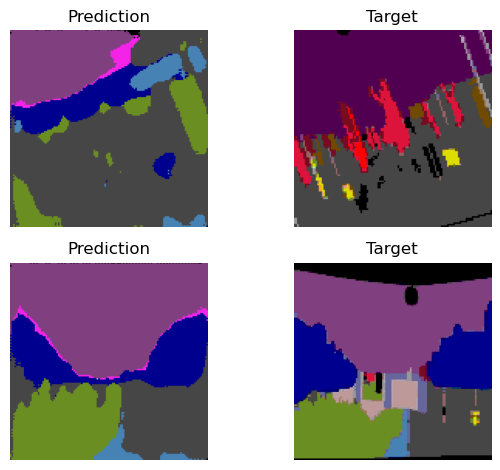

Epoch 4:   2%|▏         | 4/186 [00:12<06:26,  2.12s/batch, Loss=1.71, Pixel Accuracy=0.612, mIoU=0.0761]

In [7]:
from Training.trainer import train_fn

scaler = torch.cuda.amp.GradScaler()

start_epoch += 1 # start from the next epoch
print(f"Starting from epoch {start_epoch}")
for epoch in range(start_epoch, NUM_EPOCHS + 1):
    predictions, masks, loss = train_fn(epoch, train_loader, model, optimizer, loss_fn, scaler, device=DEVICE)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "epoch": epoch,
    }
    print(f"=> Epoch {epoch} is complete")
    save_checkpoint(checkpoint, filename=CHECKPOINT_FIlE)

    #plot some examples to see how well the model is doing with matplotlib

    import matplotlib.pyplot as plt

    try:

        """Plotting the first prediction and target"""

        predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
        predictions = predictions.unsqueeze(1)
        masks = masks.unsqueeze(1)

        plt.subplot(2, 2, 1)
        plt.imshow(decode_mask(predictions[0][0].cpu().detach().numpy()))
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(decode_mask(masks[0][0].cpu().detach().numpy()))
        plt.title('Target')
        plt.axis('off')

        # Plotting the second prediction and target
        plt.subplot(2, 2, 3)
        plt.imshow(decode_mask(predictions[1][0].cpu().detach().numpy()))
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(decode_mask(masks[1][0].cpu().detach().numpy()))
        plt.title('Target')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")
        continue


# Test Prediction

In [ ]:
import sys
sys.path.append('../')

import torch
from Models.unet import UNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the model from the checkpoint
NUM_CLASSES = 35
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_FIlE = "../Checkpoints/cityscapes_checkpoint.pth.tar"

model = UNet(in_channels=3, out_channels=NUM_CLASSES)
checkpoint = torch.load(CHECKPOINT_FIlE)
model.load_state_dict(checkpoint["state_dict"])
# print(checkpoint["epoch"])
# model.eval()

transform = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,), # Example normalization values
    ToTensorV2()
])

# Load and preprocess the image
image_dir = "F:/UNI_STUFF/Thesis/cityscapes_data/val_images/109.jpg"
mask_dir = "F:/UNI_STUFF/Thesis/cityscapes_data/val_encoded_masks/109.jpg"

image = np.array(Image.open(image_dir).convert("RGB"))
image = transform(image=image)["image"]
image /= 255.0
# input_tensor = val_transforms(image=image)["image"].unsqueeze(0)

model = model.to(DEVICE)
image = image.unsqueeze(0).to(DEVICE)


# Make predictions

with torch.no_grad():
    predictions = model(image)

# Process the predictions as needed
# ...

# Print the predictions
predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
predictions = predictions.squeeze(0).cpu().numpy()



Decode the predictions to RGB

In [ ]:
from Visualizer import plot_images

image_to_display = image.to('cpu')[0].permute(1, 2, 0).numpy() * 255.0
masks = np.array(Image.open(mask_dir))
masks = decode_mask(masks)
prediction_to_display = decode_mask(predictions)

plot_images([image_to_display, masks], ['Original Image', 'GT'], max_cols=3, figsize=(4, 3))
plot_images([image_to_display, prediction_to_display], ['Original Image', 'Prediction'], max_cols=3, figsize=(4, 3))
